In [597]:
import os
import io
import PIL.Image, PIL.ImageDraw
import matplotlib.pyplot as plt
import requests
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm


# Notebook dependencies
from IPython.display import clear_output, Image

# Custom helpers package
from helpers import *

# For reloading the package
import importlib
import sys
importlib.reload(sys.modules['helpers'])
from helpers import *

# Set cuda gpu
device_id = 1
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')


# Helper
def get_data(dataset_name, dataset_path="", download=False, img_size=64, batch_size=8):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(80),
        torchvision.transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    if dataset_name == 'cifar' or dataset_name == 'cifar10' or dataset_name == 'CIFAR10':
        dataset = torchvision.datasets.CIFAR10(root=dataset_path+'/datasets', download=download, transform=transforms)
    elif dataset_name == 'mnist' or dataset_name == 'MNIST':
        dataset = torchvision.datasets.MNIST(root=dataset_path+'/datasets', download=download, transform=transforms)
    elif dataset_name == 'celeba' or dataset_name == 'celebA' or dataset_name == 'CelebA':
        dataset = torchvision.datasets.CelebA(root=dataset_path+'/datasets', download=download, transform=transforms)
    elif dataset_name == 'dtd' or dataset_name == 'DTD':
        dataset = torchvision.datasets.DTD(root=dataset_path+'/datasets', download=download, transform=transforms)        
    else:
        raise ValueError(f'dataset_name {dataset_name} is not supported')
        
    dataloader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size, shuffle=True)        
    return dataloader


device is cuda:1


In [598]:
dataloader_dtd = get_data("dtd", "Diffusion-Models-pytorch-main/tutorial")

In [600]:
dataloader_dtd

In [280]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

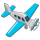

In [281]:
# CA Parameters

CHANNEL_N = 16
HIDDEN_SIZE = 128
PERCEPTION_SIZE = 48  # size of perception vector
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5
TARGET_PADDING = 16

# Don't even try pooling now

TARGET_EMOJI = "🛩"
target_img = load_emoji(TARGET_EMOJI)
imshow(target_img)

In [ ]:
# Clean way to make dataloader from single image

def make_dataloader(target_img, n_images=1, batch_size=8):
    """Take a padded emoji and make batched "dataset"
        with only that emoji as a sample.
        
        `n_images` defines how many images to put in a batch.
        Returns a list of batched images of shape [B, C, H, W]
        
        Note: Expects pad_target to have shape (4, 64, 64)
    """
    # permuted_target = torch.as_tensor(pad_target).permute(-1, 0, 1) # make it shape (C, H, W)
    # permuted_target = target_img # make it shape (C, H, W)
    
    # Remove alphas for now
    # permuted_target = permuted_target[:3, ...]
    
    batched_data = torch.repeat_interleave(target_img[None, ...], batch_size, dim=0) 
    return [(batched_data, 'label')] * n_images

dataloader = make_dataloader(target_img, n_images=200)

In [287]:
def pos_encoding(t, channels):
    """Encode time tensor using sinusoidal embedding"""
    inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device=device).float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

In [292]:
t = torch.randint(low=1, high=1000, size=(8,)).to(device)
print(t.shape, t)
t = t.unsqueeze(-1).type(torch.float)
print(t.shape)
encoded_t = pos_encoding(t, 256)
print(encoded_t.shape)
encoded_t

torch.Size([8]) tensor([803, 641, 206, 405, 595, 914, 643, 317], device='cuda:1')
torch.Size([8, 1])
torch.Size([8, 256])


tensor([[-0.9483, -0.4347, -0.8807,  ...,  0.9950,  0.9957,  0.9963],
        [ 0.1148, -0.3949,  0.8298,  ...,  0.9968,  0.9973,  0.9976],
        [-0.9746, -0.0607,  0.6305,  ...,  0.9997,  0.9997,  0.9998],
        ...,
        [ 0.2021,  0.7371, -0.1888,  ...,  0.9936,  0.9944,  0.9952],
        [ 0.8555,  0.9933, -0.6840,  ...,  0.9968,  0.9972,  0.9976],
        [ 0.2963, -0.3130, -0.9292,  ...,  0.9992,  0.9993,  0.9994]],
       device='cuda:1')

torch.Size([8, 3, 72, 72])
torch.Size([8, 16, 72, 72])


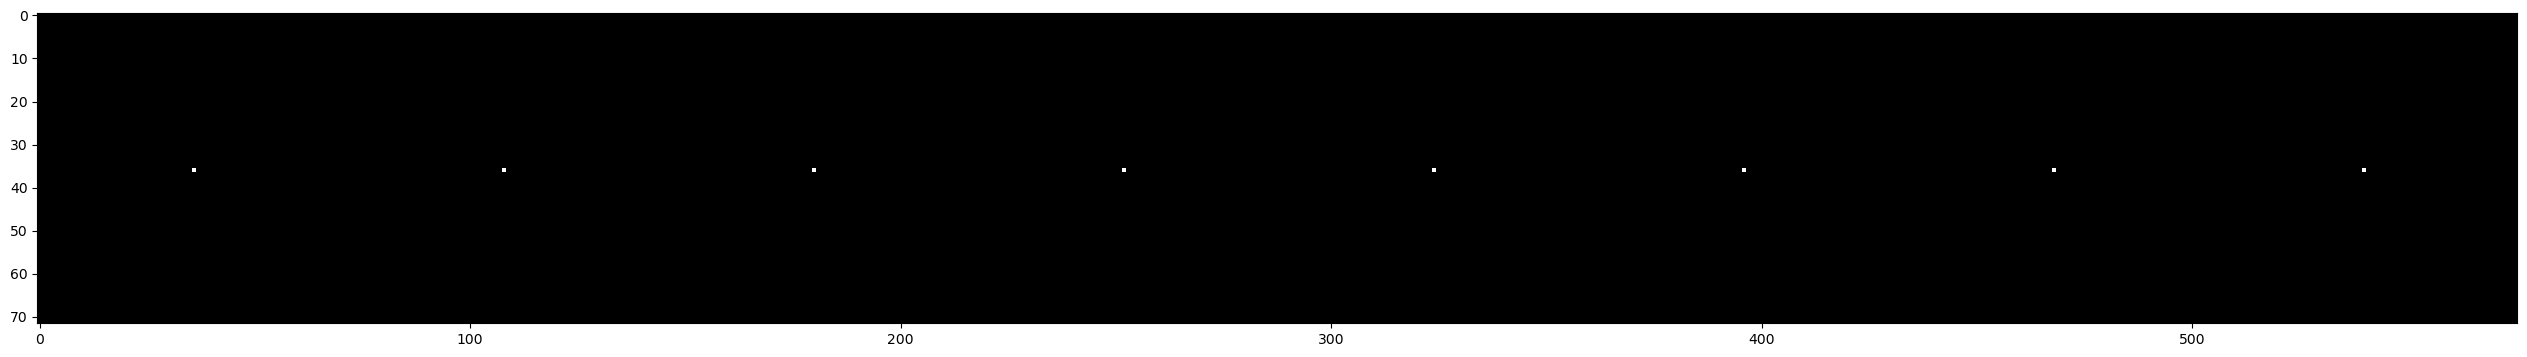

In [405]:
x_rgb = torch.randn((8, 3, 72, 72), dtype=torch.float32)
print(x_rgb.shape)
seed = torch.zeros(8, 16, 72, 72, dtype=torch.float32)
print(seed.shape)

# Set hiddens to 1 at center
seed[:, 3:, 72//2, 72//2] = 1.0
seed[:, :3, ...] = x_rgb

plot_images(seed[:, 3:6, ...])

batch (before/after):


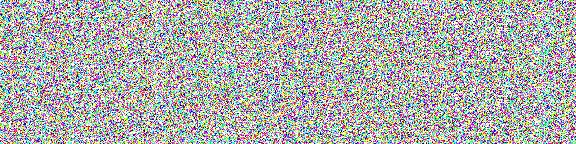

In [525]:
visualize_batch(seed, seed)

In [612]:
class DiffusionCA:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.2, c_in=3, img_size=72, device=device):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.c_in = c_in
        self.img_size = img_size
        self.device = device        
        
        # Noise scheduler and params
        self.beta = self.prepare_noise_scheduler().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        
    def prepare_noise_scheduler(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        """Noise the images stored in `x` (must be batched) for `t` timesteps. 
            Note that the reparameterization trick allows this to take
            place in a single step though.
        """
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        eps = torch.randn_like(x) # Sampled noise from Gaussian
        q_xt_given_xt_minus_1 = sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps
        
        return q_xt_given_xt_minus_1, eps
    
    def sample_timesteps(self, n):
        """Defines how many times to denoise the model, `n` being the number of
            such timesteps
        """
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n, sampled_image=None):
        """Sample `n` images using `model` to remove noise.
            Takes in a sample image to describe the initial mask. 
            If None, uses 3 input channels.
            
            This is different from the standard denoiser because the model passed
            in is theoretically a CA of sorts...
        """
        logging.info(f"Sampling {n} new images...")
        model.eval()
        with torch.no_grad():
            
            # Random noise to start with
            x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device)
            
#             x_rgb = torch.randn((n, 3, self.img_size, self.img_size), dtype=torch.float32).to(self.device)
#             x = torch.zeros(n, self.c_in, self.img_size, self.img_size, dtype=torch.float32).to(self.device)

#             # Set hiddens to 1 at center
#             x[:, 3:, self.img_size//2, self.img_size//2] = 1.0
            
#             # Noise the rgb channels
#             x[:, :3, ...] = x_rgb        
            
            # Iterate through noise steps in reverse order and denoise
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
            # for i in reversed(range(1, self.noise_steps)):
                
                # # Generate a tensor of timesteps (variable based on `i`)
                t = (torch.ones(n) * i).long().to(self.device)
                
                ## This time, will parameterize `t` by running the CA for `t` timesteps
                
                # Predict noise from model

                iter_n = np.random.randint(64, 97, dtype=np.int32)
                for _ in range(iter_n):                
                
                # for _ in range(i):
                    predicted_noise = model(x, t)
                    alpha = self.alpha[t][:, None, None, None]
                    alpha_hat = self.alpha_hat[t][:, None, None, None]
                    beta = self.beta[t][:, None, None, None]     

                    # We don't want to add noise in the last iteration
                    if i > 1:
                      noise = torch.randn_like(x)
                    else:
                      # noise = torch.zeros_like(x)
                        noise = torch.randn_like(x)

                    # Finally, alter the image with a little bit of noise according to Alg 2
                    # x_in = x[:, :3, :, :]
                    # noise = noise[:, :3, :, :]
                    x_in = x
                    # x[:, :3, :, :] = 1 / torch.sqrt(alpha) * (x_in - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) +\
                    #       torch.sqrt(beta) * noise   
                    x = 1 / torch.sqrt(alpha) * (x_in - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) +\
                          torch.sqrt(beta) * noise   

        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [613]:
class CAModel(nn.Module):
    def __init__(self, channel_n=CHANNEL_N, hidden_size=HIDDEN_SIZE, perception_size=PERCEPTION_SIZE, 
                 time_dim=256, fire_rate=CELL_FIRE_RATE):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        self.time_dim = time_dim

        # Construct learnable perception filters - instead of building a 48 long vector though, directly blow up convolution to hidden size
        self.perceive = nn.Conv2d(in_channels=self.channel_n, out_channels=perception_size, kernel_size=3, padding='same', groups=self.channel_n)
        
        # CA rule
        conv1 = nn.Conv2d(in_channels=perception_size, out_channels=hidden_size, kernel_size=1)
        conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self.channel_n, kernel_size=1)

        # Apply "do-nothing" initial behavior - not sure about this here
        # torch.nn.init.zeros_(conv2.weight)
        # torch.nn.init.zeros_(conv1.bias)
        # torch.nn.init.zeros_(conv2.bias)    
        
        self.dmodel = nn.Sequential(
            conv1,
            nn.ReLU(),
            conv2,
        )
        
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                in_features=self.time_dim, out_features=self.channel_n
            ),
        )
        
    
    def pos_encoding(self, t, channels):
        """Encode time tensor using sinusoidal embedding"""
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t, fire_rate=None, step_size=1.0):
        """Assume correct shape for x this time (according to Torch).
        
        This time we will take in the number of noising timesteps as a parameter as well."""   
        
        # pre_life_mask = get_living_mask(x)
        
        y = self.perceive(x)
        dx = self.dmodel(y)*step_size # note this now should be a noise prediction
        
#         # For stochastic update - may be unnecessary here
#         if fire_rate is None:
#             fire_rate = self.fire_rate
#         update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
        
        # Remember, we are predicting the noise this time around, which is the dx (I Think)
        
        
        # dx = (dx.clamp(-1, 1) + 1) / 2
        # dx = (dx * 255).type(torch.uint8)   
        
        # Include time embedding
        t = t.unsqueeze(-1).type(torch.float32)
        t = pos_encoding(t, self.time_dim)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        dx[:, :3, :, :] = dx[:, :3, :, :] + emb # add embedding information
        return dx 

print(CAModel().perceive)
CAModel().dmodel

Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=16)


Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

In [614]:
# Now we need to train somehow

class Train():
    def __init__(self, model, diffusion, dataloader, run_name, lr=3e-4):
        """Training class"""

        setup_logging(run_name)

        self.model = model
        self.diffusion = diffusion

        self.logger = SummaryWriter(os.path.join('runs', run_name))
        self.dataloader = dataloader
        self.run_name = run_name

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        self.mse = nn.MSELoss()

        self.l = len(dataloader)

    def train(self, epochs):

        for epoch in range(epochs):

            logging.info(f"Starting epoch {epoch}:")

            pbar = tqdm(self.dataloader)

            for i, (images, _) in enumerate(pbar):
            
                images = images.to(device)
                t = self.diffusion.sample_timesteps(images.shape[0]).to(device)

                x_t, noise = self.diffusion.noise_images(images, t)

                predicted_noise = self.model(x_t, t)

                # Also need to mask the noise
                loss = self.mse(noise, predicted_noise)

                # Backprop
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                pbar.set_postfix(MSE=loss.item())

                self.logger.add_scalar('MSE', loss.item(), global_step=i)

            sampled_images = self.diffusion.sample(self.model, n=images.shape[0])
            
            clear_output()

            save_images(sampled_images, os.path.join("results", self.run_name, f'{epoch}.png')) # change to png from jpeg
            torch.save(self.model.state_dict(), os.path.join("models", self.run_name, f'ckpt.pt'))


In [615]:
%%time

model1 = CAModel(channel_n=3).to(device)
diffusion1 = DiffusionCA(device=device, c_in=3)

train1 = Train(model1, diffusion1, dataloader_dtd, "helloworld_dtd")
train1.train(epochs=30)


CPU times: user 58min 21s, sys: 19.5 s, total: 58min 41s
Wall time: 1h 2min 4s


In [588]:

emb_dim = 256
def pos_encoding(t, channels):
    """Encode time tensor using sinusoidal embedding"""
    inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device=device).float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

emb_layer = nn.Sequential(
    nn.SiLU(),
    nn.Linear(emb_dim, 3)
).to(device)

t = (torch.ones(8) * 2).long().to(device)
t = t.unsqueeze(-1).type(torch.float).to(device)
print(t.shape)

t = pos_encoding(t, emb_dim)
print(f"t shape: {t.shape}")

emb_t = emb_layer(t)
print(emb_t.shape)
emb_t_expanded = emb_t[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
print(emb_t_expanded.shape)

torch.Size([8, 1])
t shape: torch.Size([8, 256])
torch.Size([8, 3])
torch.Size([8, 3, 72, 72])


torch.Size([8, 4, 72, 72])


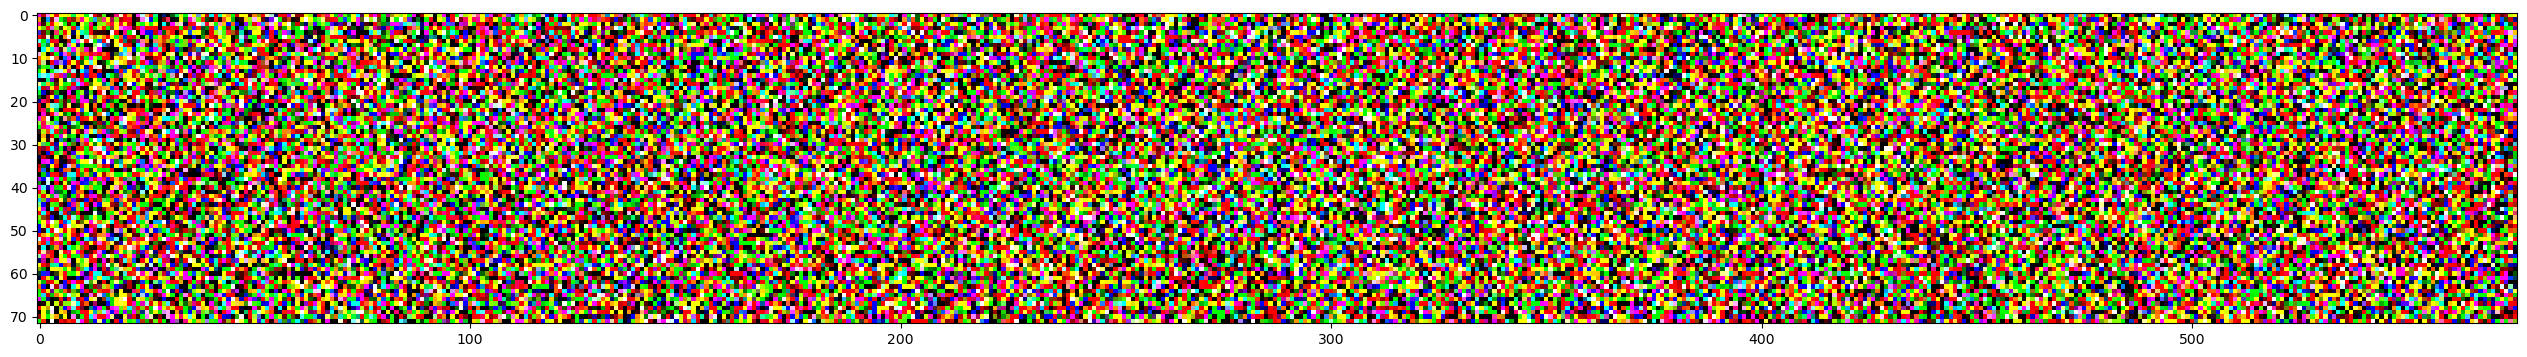

In [555]:
print(x.shape)
new_x = x[:, :3, ...] + emb_t_expanded
new_x.shape
plot_images(new_x.detach().cpu())

In [595]:
# Now we need to train somehow

class Train():
    def __init__(self, model, diffusion, target, run_name, lr=3e-4):
        """Training class"""

        setup_logging(run_name)

        self.model = model
        self.diffusion = diffusion
        self.target = target.permute(0, -1, 1, 2) # permute to shape [B, C, 72, 72]

        self.logger = SummaryWriter(os.path.join('runs', run_name))
        # self.dataloader = dataloader
        self.run_name = run_name

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        self.mse = nn.MSELoss()

        # self.l = len(dataloader)

    def train(self, n_steps):

        for i in range(n_steps):

            logging.info(f"Starting train step {i}:")

            # pbar = tqdm(self.dataloader)

            t = self.diffusion.sample_timesteps(self.target.shape[0]).to(device)

            # life_mask = get_living_mask(self.target)
            # print(f"images shape: {images.shape}, t shape: {t.shape}")

            # Pass into model without alpha channel
            # images = images[:, :3, :, :]

            x_t, noise = self.diffusion.noise_images(self.target, t)
            # print(f'x_t shape is : {x_t.shape}, noise shape is {noise.shape}')

#             seed = torch.zeros(8, 16, 72, 72, dtype=torch.float32).to(device)
            
#             # Set hiddens to 1 at center
#             seed[:, 3:, 72//2, 72//2] = 1.0
#             seed[:, :3, ...] = x_t
            
#             # x_t = seed * life_mask # mask
#             x_t = seed
            predicted_noise = self.model(x_t, t)
            # predicted_noise = predicted_noise[:, :3, :, :]

            # Also need to mask the noise
            # noise_masked = noise * life_mask
            # predicted_noise_masked = predicted_noise * life_mask
            # loss = self.mse(noise_masked, predicted_noise_masked)
            loss = self.mse(noise, predicted_noise)

            # Backprop
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # pbar.set_postfix(MSE=loss.item())
            
            self.logger.add_scalar('MSE', loss.item(), global_step=i)

            sampled_images = self.diffusion.sample(self.model, n=self.target.shape[0])
            # sampled_images = sampled_images[:, :3, :, :] # ignore hidden channels
            
            clear_output()
            print('\r step: %d, log10(loss): %.3f'%(i, np.log10(loss.item())), end='')
            # visualize_batch(sampled_images, self.target)            

            save_images(sampled_images, os.path.join("results", self.run_name, f'{i}.png')) # change to png from jpeg
            torch.save(self.model.state_dict(), os.path.join("models", self.run_name, f'ckpt.pt'))


In [412]:
p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
print(pad_target.shape)

# Make batched target
target = torch.repeat_interleave(pad_target[None, ...], BATCH_SIZE, dim=0)
print(target.shape)

torch.Size([72, 72, 4])
torch.Size([8, 72, 72, 4])


torch.Size([8, 72, 72, 4])


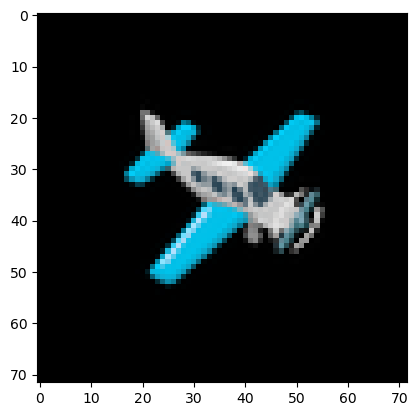

In [413]:
life_mask = get_living_mask(target.permute(0, -1, 1, 2))
print(target.shape)
plt.imshow(target[-1, ..., :3])

In [418]:
samples.nonzero().any()

tensor(False, device='cuda:1')

In [596]:
%%time

# Train the model (yikes)

ca = CAModel(channel_n=3, perception_size=27).to(device)
diffusion = DiffusionCA(c_in=3, device=device)

train = Train(ca, diffusion, target[..., :3].to(device), "helloworld_DiffusionCA")
train.train(n_steps=1000)

 step: 341, log10(loss): -0.991

673it [00:01, 457.54it/s]


KeyboardInterrupt: 

In [584]:
samples = diffusion.sample(ca, 8)

49it [00:00, 358.54it/s]


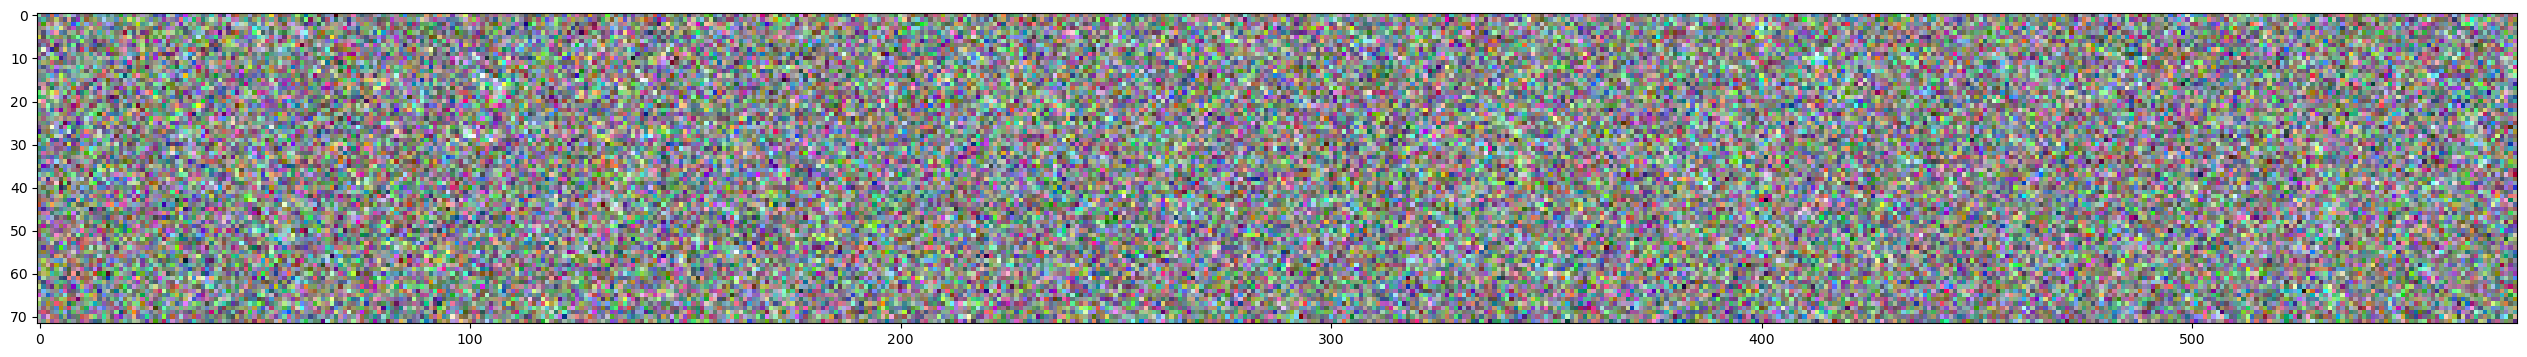

In [585]:
plot_images(samples)

In [567]:
print(x_out.min(), x_out.max())

# x_out = (x_out.clamp(-1, 1) + 1) / 2
# x_out = (x_out * 255).type(torch.uint8)
# print(x_out.min(), x_out.max())

tensor(-1.2054) tensor(0.8399)


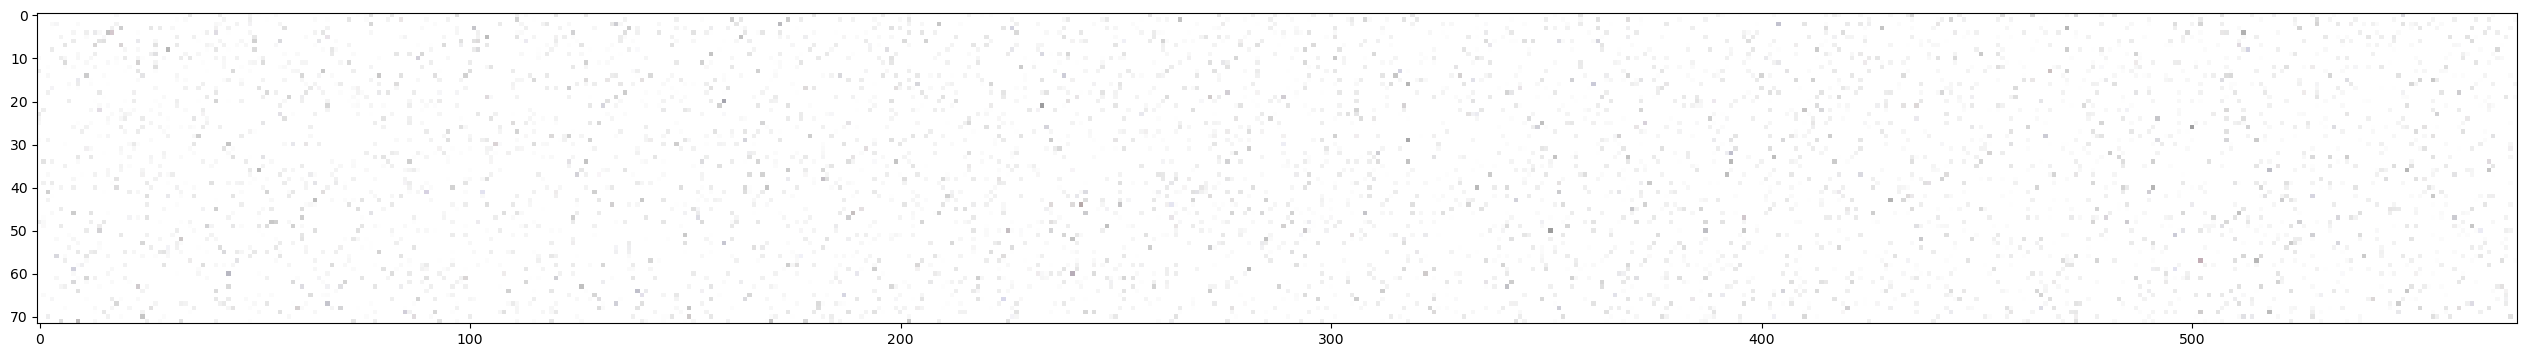

In [568]:
plot_images(x_out)

In [569]:
noise = torch.zeros_like(x)

In [509]:
diff_out.isnan().all()
diff_out.nonzero().any()

tensor(False, device='cuda:1')

In [516]:
def prepare_noise_scheduler(beta_start=1e-4, beta_end=0.2, noise_steps=1000):
    return torch.linspace(beta_start, beta_end, noise_steps)

beta_orig = prepare_noise_scheduler().to(device)
alpha_orig = 1. - beta_orig
alpha_hat_orig = torch.cumprod(alpha_orig, dim=0)

In [535]:
model.eval()
with torch.no_grad():

    # Random noise to start with
    x = torch.randn((8, 4, 72, 72)).to(device)   

    # Iterate through noise steps in reverse order and denoise
    for i in tqdm(reversed(range(1, 50)), position=0):

        # Generate a tensor of timesteps (variable based on `i`)
        t = (torch.ones(8) * i).long().to(device)

        ## This time, will parameterize `t` by running the CA for `t` timesteps

        # Predict noise from model 
        # for _ in range(i):
        predicted_noise = model(x)
        alpha = alpha_orig[t][:, None, None, None]
        alpha_hat = alpha_hat_orig[t][:, None, None, None]
        beta = beta_orig[t][:, None, None, None]     

        # We don't want to add noise in the last iteration
        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) +\
              torch.sqrt(beta) * noise  

model.train()
# x = (x.clamp(-1, 1) + 1) / 2
# x = (x * 255).type(torch.uint8)

49it [00:03, 12.83it/s]


CAModel(
  (perceive): Conv2d(4, 12, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=4)
  (dmodel): Sequential(
    (0): Conv2d(12, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [536]:
x.shape

torch.Size([8, 4, 72, 72])

In [537]:
x.nonzero().any()

tensor(True, device='cuda:1')

In [538]:
x

tensor([[[[ 1.9764,  0.1494,  1.4869,  ..., -1.2188,  0.3272, -0.2655],
          [ 0.7882, -1.9833, -0.5821,  ...,  0.6288, -1.5096, -1.0644],
          [ 1.0051, -0.3190, -0.2603,  ..., -2.2873, -0.2975, -0.2144],
          ...,
          [-1.1442,  0.5079, -2.1310,  ..., -1.0503,  0.0116,  0.7847],
          [-0.0541,  0.6595, -0.8394,  ...,  0.2995, -1.1268, -1.2893],
          [-0.8819,  0.8152, -0.5891,  ..., -1.9579,  1.0090, -0.1267]],

         [[-1.5717, -0.8428,  0.2722,  ...,  0.5850, -0.6017,  1.3212],
          [ 0.3129, -0.2050,  0.3702,  ..., -2.3655,  1.0825, -0.0286],
          [-0.6950, -0.9199,  1.6684,  ..., -2.5481, -0.7552, -2.4154],
          ...,
          [-0.4641,  0.8942,  0.3472,  ..., -1.0436,  0.3422,  1.8626],
          [-0.6040,  1.5252,  1.6225,  ...,  0.1637,  0.6283,  0.9615],
          [ 2.2087, -0.0959, -0.2367,  ..., -0.3612,  1.1298, -0.9537]],

         [[ 1.2163, -0.3243,  1.6253,  ...,  0.1486,  1.0244, -0.8042],
          [-0.0049, -0.1867,  

In [539]:
x_clamped = (x.clamp(-1, 1) + 1) / 2
print(x_clamped.shape, x_clamped.min(), x_clamped.max())
x_typed = (x_clamped * 255).type(torch.uint8)
print(x_typed.shape, x_typed.min(), x_typed.max())

torch.Size([8, 4, 72, 72]) tensor(0., device='cuda:1') tensor(1., device='cuda:1')
torch.Size([8, 4, 72, 72]) tensor(0, device='cuda:1', dtype=torch.uint8) tensor(255, device='cuda:1', dtype=torch.uint8)


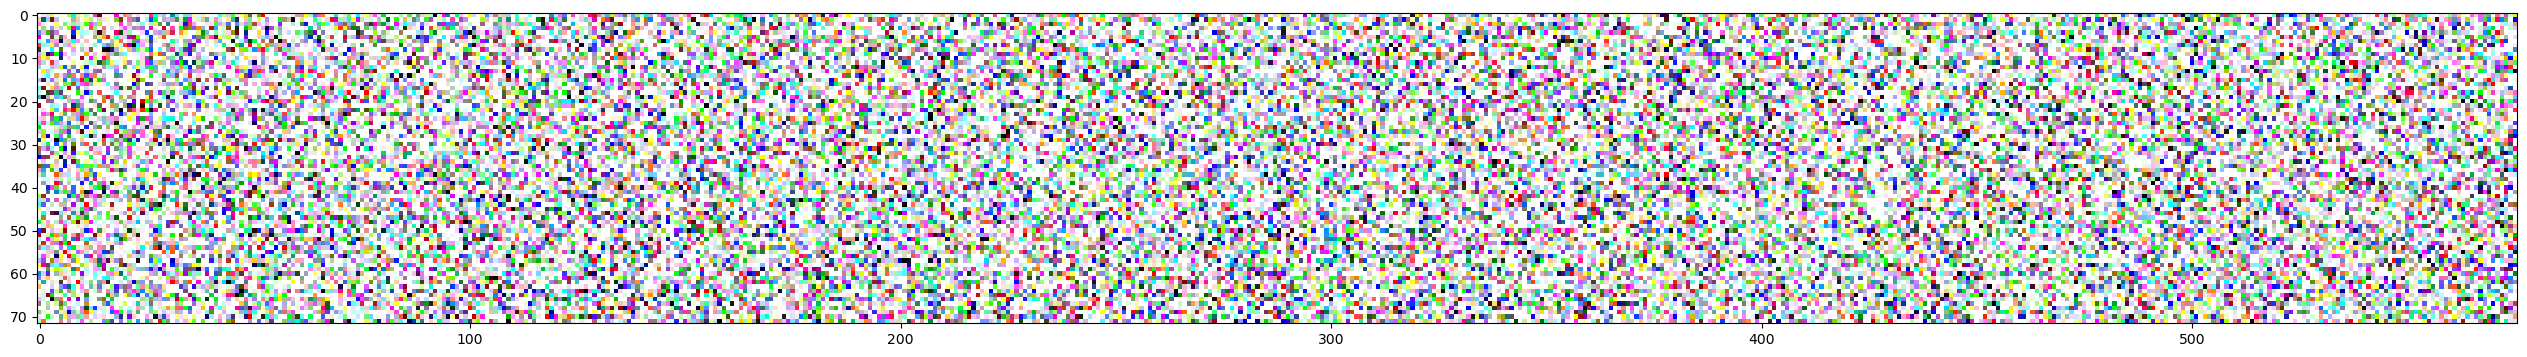

In [540]:
plot_images(x_typed)